# NN4
Tymoteusz Urban

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import copy
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    model_type : str
        model type, regressor or classifier
    layers : List
        list of layer sizes
    num_layers : int
        number of layers
    init_function : func
        
    """
    
    def __init__(self, layers, initalization='xavier', model_type='regression', weights=None, biases=None, activations=None):
        """
        activations - list of available functions: 'sigmoid', 'linear', 'softmax' ('softmax' can be used only on the last layer)
        initialization - available types: 'xavier', 'he', 'uniform'
        model_type - available types: 'regression', 'classification'
        """        
        self.layers = layers
        self.num_layers = len(layers)
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        assert model_type in ['regression', 'classification']
        self.model_type = model_type
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            if self.model_type == 'regression':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
            elif self.model_type == 'classification':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['softmax']
        else:
            self.activations = activations
        
        self.velocities_weights = [self.zeros_init(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        self.velocities_biases = [self.zeros_init(layers[i]) for i in range(1, self.num_layers)]
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear,
            'softmax': self._softmax
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / exp_z.sum(axis=1).reshape(-1,1)
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X, label=False):
        """ if to use label_predictions function """
        if label:
            return label_predictions(self.feedforward(X))
        else:
            return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def f1_score(self, X, y_true, average='weighted'):
        """
        calculates f1 score. 
        y_true : 2 dimensional array with probabilities
        average: 'weighted', 'macro'
        """
        predictions = self.predict(X)
        y_pred = label_predictions(predictions)
        y_true = label_predictions(y_true)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1
        
    def cross_entropy(self, X, y):
        """ calculates cross entropy loss """
        predictions = self.predict(X)    
        return -np.mean(np.sum(y * np.log(predictions), axis=1))
    
    def loss(self, X, y, resize=False, denormalize=None, test=False):
        """ returns appriopriate loss """
        if self.model_type == 'regression':
            return self.mse(X, y, resize=resize, denormalize=denormalize)
        elif self.model_type == 'classification':
            if test:
                return self.f1_score(X, y)
            else:
                return self.cross_entropy(X, y)
    
    def plot_classes(self, data):
        """ plots predicted classes for classifcation data. plot based only on first two columns of passed data. """
        colors = self.predict(data, label=True)
        sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def backward(self, X, y):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        if self.activations[-1] == "softmax":
            deltas[-1] = activations[-1] - y 
        elif self.activations[-1] == "linear": # linear
            deltas[-1] = activations[-1] - y
        elif self.activations[-1] == "sigmoid":
            deltas[-1] = (activations[-1] - y) * self.sigmoid_derivative(activations[-1])
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
            elif self.activations[i] == "softmax":
                raise AssertionError("softmax can be used only on the last layer")
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate, optimize=None, optimize_param=0.9):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y)
        for i in range(len(self.weights)):
            
            if optimize is None:
                self.weights[i] = self.weights[i] - (learning_rate/m) * weights_gradient[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * biases_gradient[i]
            
            elif optimize == 'moment':
                self.velocities_weights[i] = weights_gradient[i] + self.velocities_weights[i] * optimize_param
                self.velocities_biases[i] = biases_gradient[i] + self.velocities_biases[i] * optimize_param
            
                self.weights[i] = self.weights[i] - (learning_rate/m) * self.velocities_weights[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * self.velocities_biases[i]            
            
            elif optimize == 'rmsprop':
                self.velocities_weights[i] = optimize_param * self.velocities_weights[i] + (1-optimize_param) * (weights_gradient[i]**2)
                self.velocities_biases[i] = optimize_param * self.velocities_biases[i] + (1-optimize_param) * (biases_gradient[i]**2)
                
                self.weights[i] = self.weights[i] - (learning_rate/m) * (weights_gradient[i]/np.sqrt(self.velocities_weights[i]))
                self.biases[i] = self.biases[i] - (learning_rate/m) * (biases_gradient[i]/np.sqrt(self.velocities_biases[i]))
    
    def create_batches(self, X, y, batch_size):
        """ creates batches """
        N = len(X)
        combined_data = list(zip(X, y))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False, 
              optimize=None, optimize_param=0.9, 
              X_test=None, y_test=None, cutoff=None, cutoff_inverse=False, resize=False, denormalize=None,
              info_interval=500, mute_print=False):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        denormalize: a tuple (mean, std) for denormalizing target for calculating mse
        info_interval: number of epochs between logging, set to None to turn off console output
        optimize: 'moment' or 'rmsprop'
        """
        assert optimize is None or optimize in ['moment', 'rmsprop'], f"optimize should be None or in ['moment', 'rmsprop']"
        
        # setting flags
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
        
        # resizing
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        # denormalizing for testing
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = History()
        
        for epoch in range(1, epochs+1):
            
            # mini batch
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate, optimize, optimize_param)
            else:
                self.update_weights(X, y, learning_rate, optimize, optimize_param)
            
            # logging
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.loss(X, y_mse, denormalize=denormalize)
                history.loss.append(loss)
                history.loss_epochs.append(epoch)
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    loss_test = self.loss(X_test, y_test, denormalize=denormalize, test=True)   
                    history.test_loss.append(loss_test)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                if not mute_print:
                    print(training_info)
            
            history.weights.append(copy.deepcopy(self.weights))
            history.biases.append(copy.deepcopy(self.biases))
            
            # early stopping
            if early_stopping:
                loss_es = self.loss(X_test, y_test, denormalize=denormalize, test=True)
                if (loss_es <= cutoff and not cutoff_inverse) or (loss_es >= cutoff and cutoff_inverse):
                    loss = self.loss(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    training_info += f" Test Loss = {round(loss_es, 3)}"
                    print(training_info)
                    break
        
        if return_history:
            history.model_type = self.model_type
            return history

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]


def label_predictions(y_pred, class_order=None):
    """
    y_pred : 2 dimensional array
    class_order : default [..., 2, 1, 0]
    """
    if class_order is None:
        class_order = np.array(range(len(y_pred[0])))
    max_indices = np.argmax(y_pred, axis=1)
    return class_order[max_indices]

def one_hot_encode(y):
    """ y : pd.Series """
    return pd.get_dummies(y, dtype=int).to_numpy()

def plot_classes(data, colors):
    sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)

def mse(y_true, y_pred):
    """ calculated mse """
    return np.mean((y_pred - y_true) ** 2)

def cross_entropy(y_true, y_pred):
    """ calculates cross entropy loss, y_true and y_pred should be 2-dimensional """
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
class History:
    """
    Class which attributes are weights from all training epochs 
    and loss for chosen loss_epochs (usually epochs with some interval)
    """
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.loss = []
        self.test_loss = []
        self.loss_epochs = []
        self.model_type = 'regression'
    
    def plot_weights(self, layer, bias=False, return_plot=False):
        """
        layer - integer, index of weights vector
        if to plot bias instead of weights 
        """
        weights = []
        weights_type = 'Weights'
        if bias:
            weights_type = 'Biases'
            for epoch in self.biases:
                weights.append(epoch[layer].flatten())
        else:
            for epoch in self.weights:
                weights.append(epoch[layer].flatten())

        weights = np.array(weights)
        for i in range(weights.shape[1]):
            w_y = weights[:,i]
            plt.plot(range(len(self.weights)), w_y)
            
        plt.xlabel('Epochs')
        plt.title(f'{weights_type} values vs epochs at layer {layer}')
        if return_plot:
            return plt
        else:
            plt.show()
        
    def plot_loss(self, test=False, return_plot=False, settings=''):
        if test:
            plt.plot(self.loss_epochs, self.test_loss, settings)
            plt.title('Test loss history')
        else:
            plt.plot(self.loss_epochs, self.loss, settings)
            plt.title('Training loss history')
        plt.xlabel('Epochs')
        if self.model_type == 'classification':
            plt.ylabel('Cross Entropy')
        else: 
            plt.ylabel('MSE')
        if return_plot:
            return plt
        else:
            plt.show()

## kryterium f1-score

### easy

In [3]:
easy_test = pd.read_csv("../dane/classification/easy-test.csv")
easy_train = pd.read_csv("../dane/classification/easy-training.csv")

In [4]:
X_train = easy_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(easy_train['c'])
X_test = easy_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(easy_test['c'])

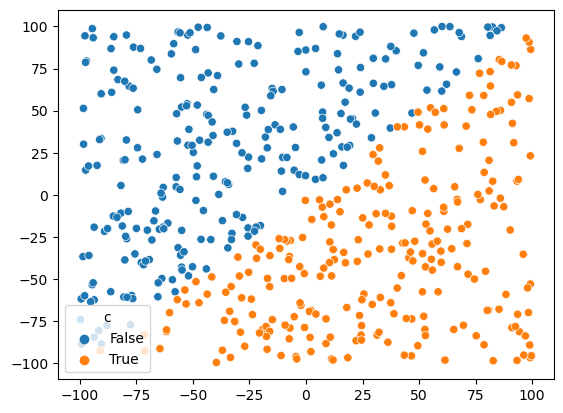

In [104]:
plot_classes(X_train, colors=easy_train['c'])

In [11]:
nn = NeuralNetwork([2,2,2], model_type='classification', initalization='he')

In [12]:
nn.train(X_train, y_train, learning_rate=0.1, info_interval=2, epochs=50, batch_size=25, X_test=X_test, y_test=y_test,
         cutoff=0.998, cutoff_inverse=True)

Epoch 2: Loss = 0.236 Test Loss = 0.986
Epoch 4: Loss = 0.324 Test Loss = 0.946
Epoch 6: Loss = 0.155 Test Loss = 0.992
Epoch 8: Loss = 0.32 Test Loss = 0.922
Epoch 10: Loss = 0.224 Test Loss = 0.95
Epoch 12: Loss = 0.102 Test Loss = 0.998
Epoch 12: Loss = 0.102 Test Loss = 0.998


In [18]:
nn.f1_score(X_test, y_test)

0.998000024000864

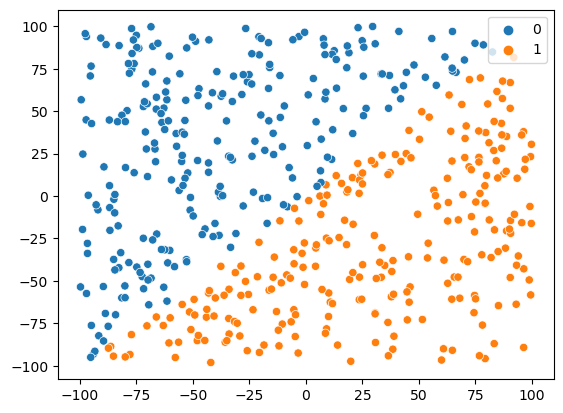

In [19]:
nn.plot_classes(X_test)

### rings3-regular

In [5]:
rings3_test = pd.read_csv("../dane/classification/rings3-regular-test.csv")
rings3_train = pd.read_csv("../dane/classification/rings3-regular-training.csv")

In [21]:
X_train = rings3_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings3_train['c'])
X_test = rings3_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(rings3_test['c'])

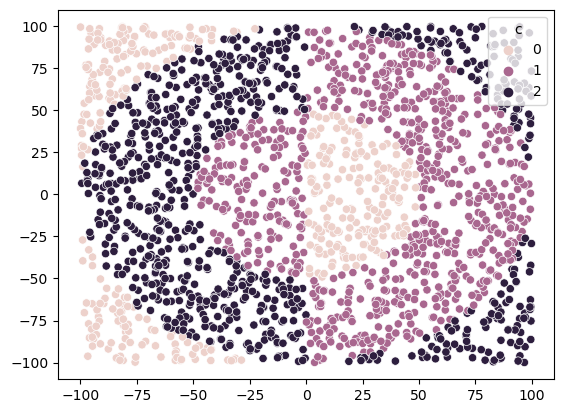

In [9]:
plot_classes(X_test, rings3_test['c'])

In [96]:
nn = NeuralNetwork([2,5,5,3], model_type='classification', initalization='xavier')

In [97]:
nn.train(X_train, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=125,
         X_test=X_test, y_test=y_test, optimize='moment', cutoff=0.75, cutoff_inverse=True)

Epoch 100: Loss = 0.992 Test Loss = 0.478
Epoch 200: Loss = 0.922 Test Loss = 0.531
Epoch 300: Loss = 0.888 Test Loss = 0.592
Epoch 400: Loss = 0.886 Test Loss = 0.581
Epoch 500: Loss = 0.73 Test Loss = 0.655
Epoch 600: Loss = 0.691 Test Loss = 0.679
Epoch 700: Loss = 0.704 Test Loss = 0.652
Epoch 800: Loss = 0.741 Test Loss = 0.628
Epoch 900: Loss = 0.841 Test Loss = 0.62
Epoch 1000: Loss = 0.674 Test Loss = 0.664
Epoch 1100: Loss = 0.737 Test Loss = 0.641
Epoch 1123: Loss = 0.648 Test Loss = 0.752


In [100]:
nn.f1_score(X_test, y_test)

0.7515298758035324

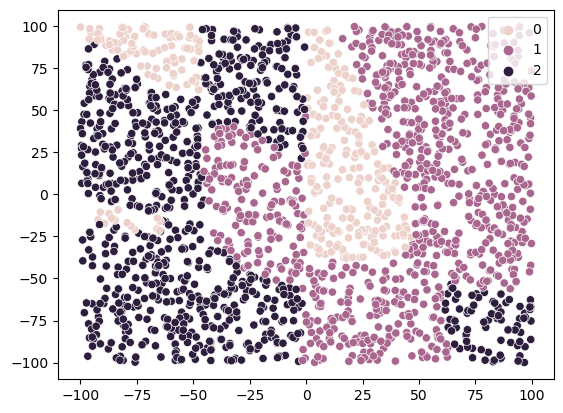

In [98]:
nn.plot_classes(X_test)

### xor

In [63]:
xor3_test = pd.read_csv("../dane/classification/xor3-test.csv")
xor3_train = pd.read_csv("../dane/classification/xor3-training.csv")

In [64]:
X_train = xor3_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(xor3_train['c'])
X_test = xor3_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(xor3_test['c'])

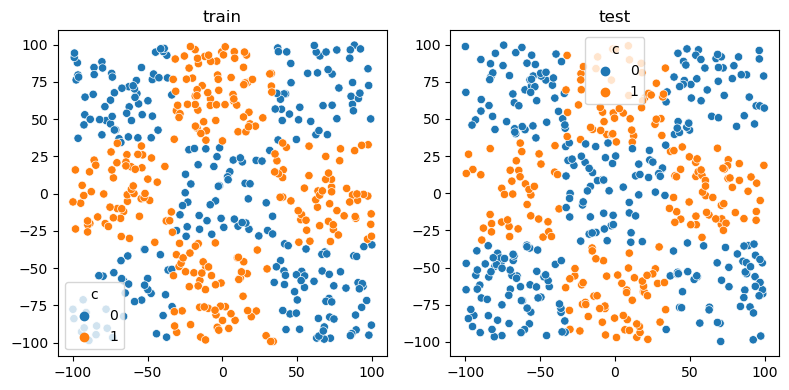

In [70]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plot_classes(X_train, xor3_train['c'])
plt.title('train')
plt.subplot(1, 2, 2)
plot_classes(X_test, xor3_test['c'])
plt.title('test')
plt.tight_layout()

In [192]:
nn_xor = NeuralNetwork([2,16,16,2], model_type='classification')

In [186]:
nn_xor.train(X_train, y_train, learning_rate=0.0001, info_interval=500, epochs=50000, batch_size=125,
         X_test=X_test, y_test=y_test, optimize='moment', cutoff=0.97, cutoff_inverse=True)

Epoch 500: Loss = 0.074 Test Loss = 0.911
Epoch 1000: Loss = 0.073 Test Loss = 0.915
Epoch 1500: Loss = 0.073 Test Loss = 0.911
Epoch 2000: Loss = 0.073 Test Loss = 0.913
Epoch 2500: Loss = 0.073 Test Loss = 0.911
Epoch 3000: Loss = 0.073 Test Loss = 0.909
Epoch 3500: Loss = 0.072 Test Loss = 0.917
Epoch 4000: Loss = 0.072 Test Loss = 0.911
Epoch 4500: Loss = 0.072 Test Loss = 0.911
Epoch 5000: Loss = 0.072 Test Loss = 0.911
Epoch 5500: Loss = 0.072 Test Loss = 0.911
Epoch 6000: Loss = 0.071 Test Loss = 0.911
Epoch 6500: Loss = 0.072 Test Loss = 0.907
Epoch 7000: Loss = 0.071 Test Loss = 0.909
Epoch 7500: Loss = 0.071 Test Loss = 0.907
Epoch 8000: Loss = 0.071 Test Loss = 0.907
Epoch 8500: Loss = 0.071 Test Loss = 0.913
Epoch 9000: Loss = 0.071 Test Loss = 0.907
Epoch 9500: Loss = 0.071 Test Loss = 0.911
Epoch 10000: Loss = 0.071 Test Loss = 0.909
Epoch 10500: Loss = 0.071 Test Loss = 0.909
Epoch 11000: Loss = 0.071 Test Loss = 0.909
Epoch 11500: Loss = 0.07 Test Loss = 0.913
Epoch 120

In [194]:
nn_xor.f1_score(X_test, y_test)

0.9124877412623892

In [193]:
nn_xor.f1_score(X_train, y_train)

0.975999615993856

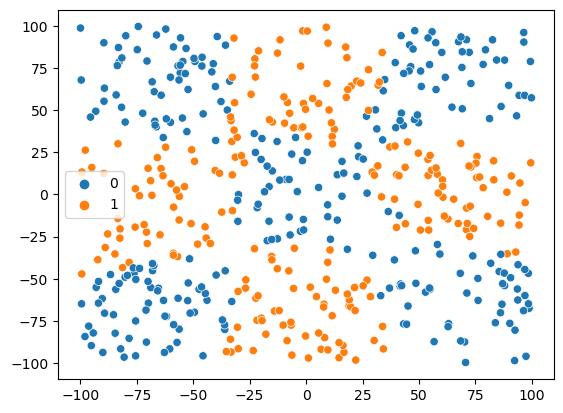

In [190]:
nn_xor.plot_classes(X_test)

In [195]:
nn_big = NeuralNetwork([2,64,64,2], model_type='classification')

In [197]:
nn_big.train(X_train, y_train, learning_rate=0.001, info_interval=500, epochs=50000, batch_size=125,
         X_test=X_test, y_test=y_test, optimize='moment', cutoff=0.97, cutoff_inverse=True)

Epoch 500: Loss = 0.051 Test Loss = 0.914
Epoch 1000: Loss = 0.048 Test Loss = 0.917
Epoch 1500: Loss = 0.052 Test Loss = 0.92
Epoch 2000: Loss = 0.047 Test Loss = 0.922
Epoch 2500: Loss = 0.047 Test Loss = 0.907
Epoch 3000: Loss = 0.048 Test Loss = 0.92
Epoch 3500: Loss = 0.049 Test Loss = 0.911
Epoch 4000: Loss = 0.045 Test Loss = 0.916
Epoch 4500: Loss = 0.057 Test Loss = 0.92
Epoch 5000: Loss = 0.042 Test Loss = 0.924
Epoch 5500: Loss = 0.065 Test Loss = 0.92
Epoch 6000: Loss = 0.041 Test Loss = 0.922
Epoch 6500: Loss = 0.041 Test Loss = 0.915
Epoch 7000: Loss = 0.039 Test Loss = 0.92
Epoch 7500: Loss = 0.041 Test Loss = 0.915
Epoch 8000: Loss = 0.041 Test Loss = 0.922
Epoch 8500: Loss = 0.041 Test Loss = 0.916
Epoch 9000: Loss = 0.065 Test Loss = 0.918
Epoch 9500: Loss = 0.036 Test Loss = 0.921
Epoch 10000: Loss = 0.037 Test Loss = 0.926
Epoch 10500: Loss = 0.04 Test Loss = 0.919
Epoch 11000: Loss = 0.038 Test Loss = 0.915
Epoch 11500: Loss = 0.034 Test Loss = 0.917
Epoch 12000: L

## Eksperymenty

In [6]:
from matplotlib.patches import Patch

### klasyfikacja binarna

In [94]:
X_train = easy_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(easy_train['c'])
X_test = easy_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(easy_test['c'])

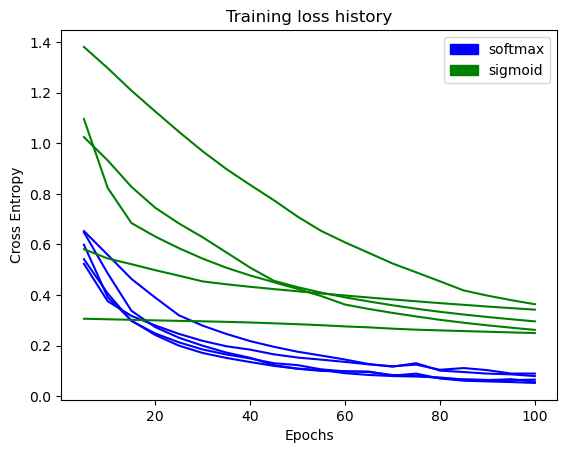

In [107]:
last_layers = ['softmax', 'sigmoid']
colors = ['b', 'g']
legend_handles = [Patch(color=color, label=label) for label, color in zip(last_layers, colors)]
for layer, color in zip(last_layers, colors):
    activations = ['sigmoid', layer]
    for i in range(5):
        nn = NeuralNetwork([2,4,2], model_type='classification', activations=activations)
        history = nn.train(X_train, y_train, learning_rate=0.05, info_interval=5, epochs=100, batch_size=125,
                 X_test=X_test, y_test=y_test, return_history=True, mute_print=True)
        history.plot_loss(return_plot=True, settings=color)
    plt.legend(handles=legend_handles)

Widzimy, że softmax radzi sobie o wiele lepiej, zbieżność jest o wiele szybsza.

### klasyfikacja wieloklasowa

In [7]:
X_train = rings3_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings3_train['c'])
X_test = rings3_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(rings3_test['c'])

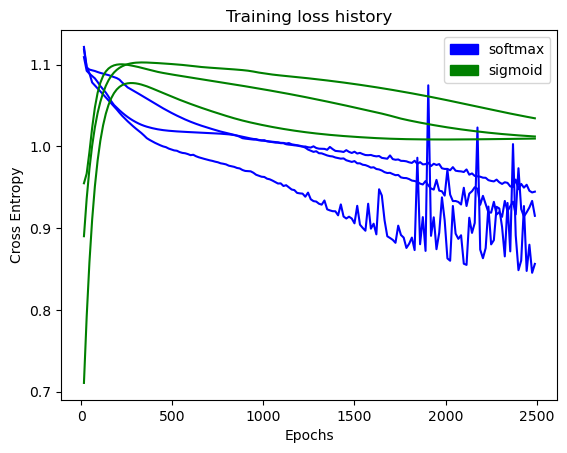

In [8]:
last_layers = ['softmax', 'sigmoid']
colors = ['b', 'g']
legend_handles = [Patch(color=color, label=label) for label, color in zip(last_layers, colors)]
for layer, color in zip(last_layers, colors):
    activations = ['sigmoid', 'sigmoid', layer]
    for i in range(3):
        nn = NeuralNetwork([2,5,5,3], model_type='classification', activations=activations)
        history = nn.train(X_train, y_train, learning_rate=0.01, info_interval=15, epochs=2500, batch_size=125,
                 X_test=X_test, y_test=y_test, return_history=True, mute_print=True)
        history.plot_loss(return_plot=True, settings=color)
    plt.legend(handles=legend_handles)

Początkowe wartości cross entropii mogą się wydawać dziwne, ale wynikają one z tego, że wartości w softmax zawsze się sumują do 1, a w sigmoidzie nie. Przez to może zdarzyć się sytuacja, że dla sigmoidy wartości wszystkich neuronów będą duże, i z tego powodu wartość entropii krzyżowej będzie mała (pomimo tego, że wartości neuronów będą do siebie podobne i klasy będą nierozróżnialne). W przypadku softmax taka sytuacja nie może wystąpić, gdyż prawdziwy neuron będzie miał dużą wartość wtedy i tylko wtedy gdy pozostałe będą małe. Przykładowo:  

In [62]:
y_true = np.array([[0,0,1]])
y_pred_sig = np.array([[0.8, 0.8, 0.8]])
print("sigmoid cross entropy:", cross_entropy(y_true, y_pred_sig))
y_pred_soft = np.array([[0.25, 0.25, 0.5]])
print("softmax cross entropy:", cross_entropy(y_true, y_pred_soft))

sigmoid cross entropy: 0.2231435513142097
softmax cross entropy: 0.6931471805599453


Sigmoid ma mniejszą wartość cross entropii, choć klasy są nierozróżnialne w przeciwieństwie do softmax, gdzie cross entropia jest wyższa, ale klasyfikator dobrze przyporządkowuje do klasy. Najprawdopobniej taka sytuacja ma miejsce w początkowym etapie uczenia naszej sieci.